In [1]:
#Import necessary libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Membuat class myCallback untuk menghentikan training ketika akurasi sudah mencapai 86% dan val_acc sudah mencapai 86%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.84 and logs.get('val_acc') > 0.84:
            print("\nAkurasi telah mencapai >86%!")
            self.model.stop_training = True

In [3]:
# Load the dataset
data = pd.read_csv('data/Emotion_classify_Data.csv')

In [4]:
#Exploring the dataset:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


In [5]:
data.head(7)

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear
5,i feel jealous becasue i wanted that kind of l...,anger
6,when a friend of mine keeps telling me morbid ...,anger


In [6]:
data.tail(7)

,Comment,Emotion
5930,i think we often feel this way about planting ...,fear
5931,i have lost touch with the things that i feel ...,joy
5932,i begun to feel distressed for you,fear
5933,i left feeling annoyed and angry thinking that...,anger
5934,i were to ever get married i d have everything...,joy
5935,i feel reluctant in applying there because i w...,fear
5936,i just wanted to apologize to you because i fe...,anger


In [7]:
data['Emotion'].value_counts()

Emotion
anger    2000
joy      2000
fear     1937
Name: count, dtype: int64

In [8]:
#Data Preprocessing:
X = data['Comment']
y = data['Emotion']

In [9]:
#Converting labels to numerical format:
le = LabelEncoder()
y = le.fit_transform(y)

In [10]:
#Split the dataset into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
#Tokensize and pad teh sequences:
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_text_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

In [12]:
#Build the deep learning model:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=16, input_length=max_len),
    tf.keras.layers.LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [13]:
# lihat arsitektur model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 180931 (706.76 KB)
Trainable params: 180931 (706.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
from keras.callbacks import TensorBoard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [14]:
# Compile a Model

"""
Kasus yang dihadapi disini adalah binary class jadi kita harus menggunakan loss function yang bernama binary crossentropy

"""
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=['acc']  
)

# Train the model

callbacks = myCallback()

history = model.fit(
    X_train_seq, 
    y_train, 
    epochs=10, 
    validation_data=(X_text_seq, y_test), 
    batch_size=32,
    # callbacks=[tensorboard_callback]
    )



Epoch 1/10


149/149 [==============================] - 15s 73ms/step - loss: 1.0675 - acc: 0.4192 - val_loss: 0.9520 - val_acc: 0.6027
Epoch 2/10
149/149 [==============================] - 10s 70ms/step - loss: 0.7226 - acc: 0.7534 - val_loss: 0.5724 - val_acc: 0.8013
Epoch 3/10
149/149 [==============================] - 10s 67ms/step - loss: 0.2437 - acc: 0.9360 - val_loss: 0.3047 - val_acc: 0.9091
Epoch 4/10
149/149 [==============================] - 11s 74ms/step - loss: 0.0920 - acc: 0.9802 - val_loss: 0.2657 - val_acc: 0.9099
Epoch 5/10
149/149 [==============================] - 10s 65ms/step - loss: 0.0573 - acc: 0.9874 - val_loss: 0.2120 - val_acc: 0.9377
Epoch 6/10
149/149 [==============================] - 9s 61ms/step - loss: 0.0406 - acc: 0.9920 - val_loss: 0.2635 - val_acc: 0.9184
Epoch 7/10
149/149 [==============================] - 9s 63ms/step - loss: 0.0280 - acc: 0.9952 - val_loss: 0.2089 - val_acc: 0.9360
Epoch 8/10
149/149 [==============================] - 9s 62ms

In [60]:
# Save the model to a file
model.save('model_emotion.h5')

c:\Users\arief\miniconda3\envs\tf\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [61]:
# Load the saved model
load_model = tf.keras.models.load_model('model_emotion.h5')

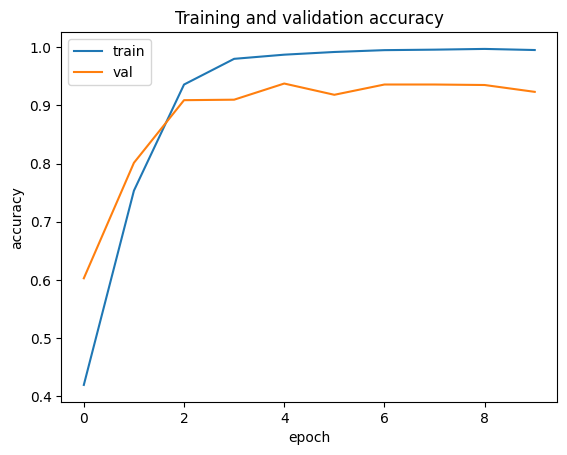

In [18]:
import matplotlib.pyplot as plt

# Retrieve a list of list results on training and test data sets for each training epoch

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']


# Plot training and validation accuracy per epoch

plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [19]:
# Evaluate the model
y_pred_prob = model.predict(X_text_seq)
y_pred = np.argmax(y_pred_prob, axis=1)

print(classification_report(y_test, y_pred))

38/38 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       392
           1       0.95      0.94      0.94       416
           2       0.95      0.87      0.91       380

    accuracy                           0.92      1188
   macro avg       0.93      0.92      0.92      1188
weighted avg       0.93      0.92      0.92      1188



In [31]:
 # Display actual vs predicted emotions
for i in range(3):  # Display the first 5 examples
    actual_emotion = le.classes_[y_test[i]]
    predicted_emotion = le.classes_[y_pred[i]]
    text = X_test.iloc[i]
    
    print(f"Example {i+1}:\n"
          f"Actual Emotion: {actual_emotion}\n"
          f"Predicted Emotion: {predicted_emotion}\n"
          f"Text: {text}\n"
          f"{'='*50}\n")

Example 1:
Actual Emotion: anger
Predicted Emotion: anger
Text: i do give up at times when i feel there s no point in a friendship when one cant be bothered

Example 2:
Actual Emotion: joy
Predicted Emotion: joy
Text: im a firm believer that nothing makes a woman feel much more terrific than a great trip to the salon to lift her spirits a bit

Example 3:
Actual Emotion: fear
Predicted Emotion: fear
Text: i was feeling very vulnerable and down no one really close to me has ever died before i either hadnt known them very well or was too young to remember

